In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags, find_peaks_cwt
from scipy.integrate import trapz
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes
import cmocean

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load the elevation and salinity data

In [2]:
#load the SCHA filtered signal for Point Reyes 
#use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"}).dropna()
pr_filt.set_index("datetime",inplace=True)
pr_filt

,Residual
datetime,
2012-02-12 01:30:00,0.057819
2012-02-12 02:00:00,0.059018
2012-02-12 02:30:00,0.060316
2012-02-12 03:00:00,0.061613
2012-02-12 03:30:00,0.062910
...,...
2023-11-19 20:30:00,-0.110012
2023-11-19 21:00:00,-0.109173
2023-11-19 21:30:00,-0.108133


In [3]:
jp=pd.read_csv('/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/jp_tidal_40dbc_filt.csv')
jp['datetime']=pd.to_datetime(jp['datetime'],format=dtformat)
jp.set_index("datetime",inplace=True)

hol2=pd.read_csv('/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/hol2_tidal_40dbc_filt.csv')
hol2['datetime']=pd.to_datetime(hol2['datetime'],format=dtformat)
hol2.set_index("datetime",inplace=True)

hol2

,S_residual[microS/cm]
datetime,
2009-10-17 16:00:00,-12.058701
2009-10-17 16:15:00,-12.018046
2009-10-17 16:30:00,-11.978434
2009-10-17 16:45:00,-11.939883
2009-10-17 17:00:00,-11.902413
...,...
2025-07-25 18:00:00,4.975943
2025-07-25 18:15:00,4.874773
2025-07-25 18:30:00,4.773693


# Compute the cross correlations

In [4]:
#need to downsample the salinity data so it is the same frequency as the pr data
jp_ds=jp.resample('30min').mean()
hol2_ds=hol2.resample('30min').mean()

In [5]:
#then need to trim all the data to be the same period of time
print('PR: '+ str(pr_filt.first_valid_index()) +' - '+ str(pr_filt.last_valid_index()))
print('JP: '+ str(jp_ds.first_valid_index()) +' - '+ str(jp_ds.last_valid_index()))
print('HOL2: '+ str(hol2_ds.first_valid_index()) +' - '+ str(hol2_ds.last_valid_index()))

PR: 2012-02-12 01:30:00 - 2023-11-19 22:30:00
JP: 2009-10-12 19:00:00 - 2025-02-06 20:00:00
HOL2: 2009-10-17 16:00:00 - 2025-07-25 19:00:00


In [6]:
# PR starts and ends first
jp_ds=jp_ds.loc[pr_filt.first_valid_index():pr_filt.last_valid_index()].values
hol2_ds=hol2_ds.loc[pr_filt.first_valid_index():pr_filt.last_valid_index()].values

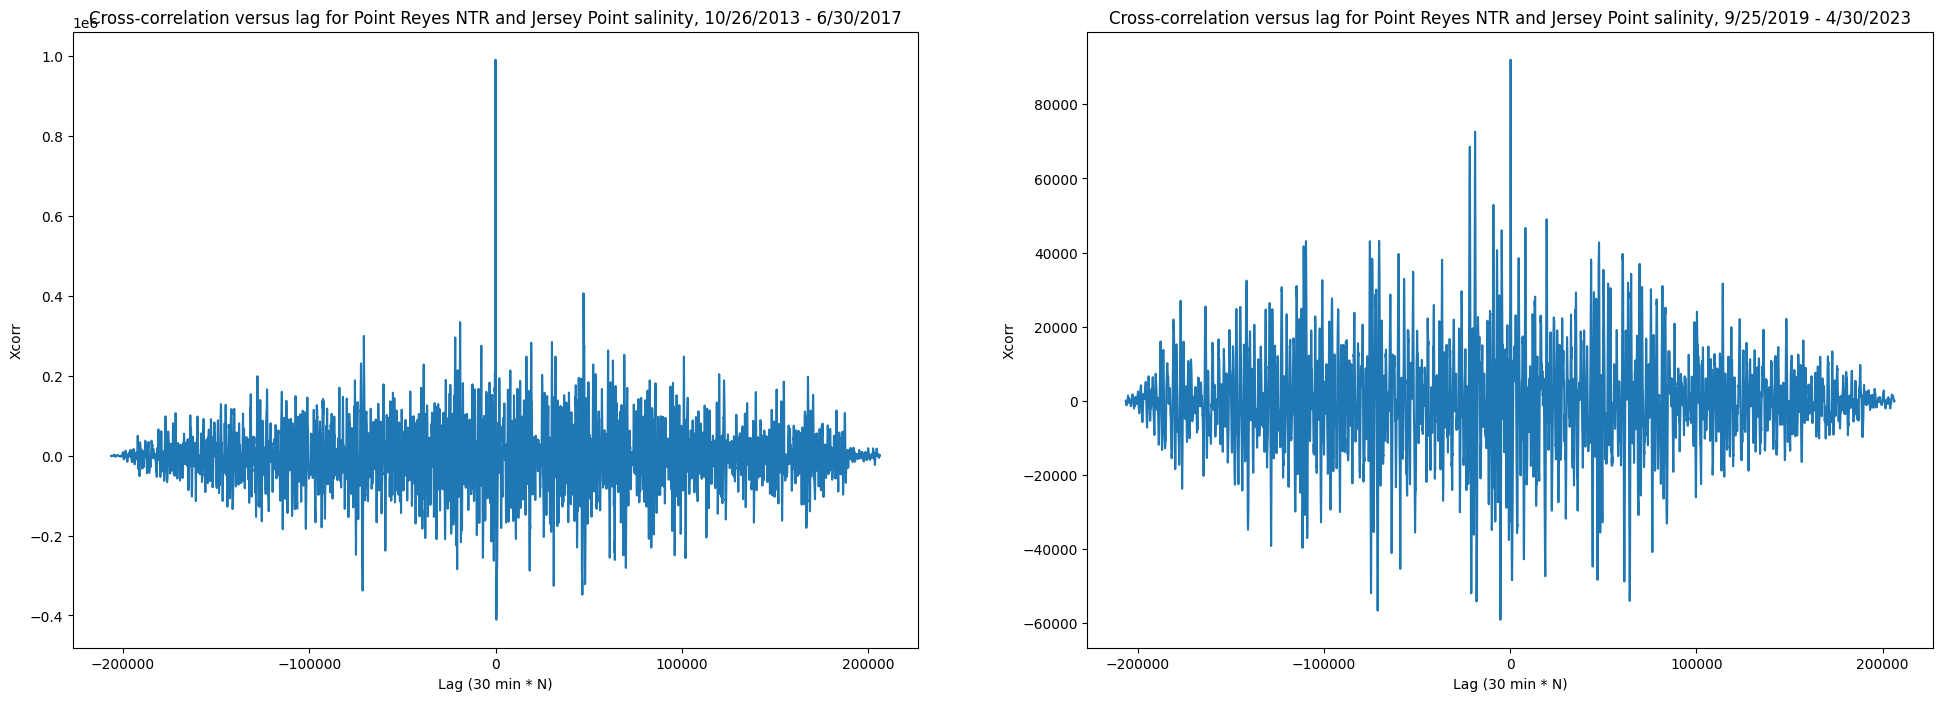

Lag of max cross-correlation for period 1 is 13.0 hours
Lag of max cross-correlation for period 2 is 148.5 hours


In [7]:
# compute the  cross correlations
corrjp = correlate(jp_ds,pr_filt)
lagsjp = correlation_lags(len(jp_ds),len(pr_filt))
corrhol2 = correlate(hol2_ds,pr_filt)
lagshol2 = correlation_lags(len(hol2_ds),len(pr_filt))

fig, ax= plt.subplots(1,2,figsize=(24,8))
ax[0].plot(lagsjp,corrjp)
ax[0].set_xlabel('Lag (30 min * N)')
ax[0].set_ylabel('Xcorr')
ax[0].set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity, 10/26/2013 - 6/30/2017')

ax[1].plot(lagshol2,corrhol2)
ax[1].set_xlabel('Lag (30 min * N)')
ax[1].set_ylabel('Xcorr')
ax[1].set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity, 9/25/2019 - 4/30/2023')
plt.show()
print('Lag of max cross-correlation for period 1 is '+ str(lagsjp[corrjp.argmax()]*0.5)+ ' hours')
print('Lag of max cross-correlation for period 2 is '+ str(lagshol2[corrhol2.argmax()]*0.5)+ ' hours')

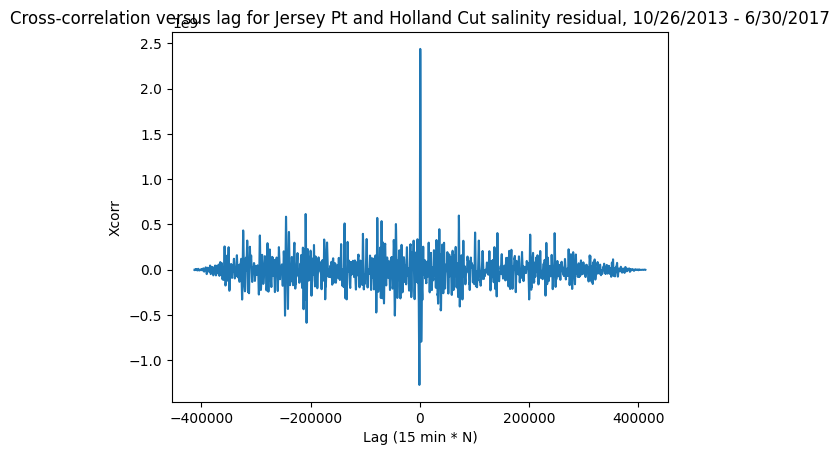

Lag of max cross-correlation for period 1 is 145.0 hours


In [8]:
# What about the correlation between JP and HOL2
#do not down sample
#first trim Hol2 starts later and JP ends first, but maybe constrain time frame to when the Pt reyes data is 
# jp_trim=jp.loc[hol2.first_valid_index():jp.last_valid_index()]
# hol2_trim=hol2.loc[hol2.first_valid_index():jp.last_valid_index()]
jp_trim=jp.loc[pr_filt.first_valid_index():pr_filt.last_valid_index()]
hol2_trim=hol2.loc[pr_filt.first_valid_index():pr_filt.last_valid_index()]
# compute the  cross correlations
corrjh = correlate(hol2_trim,jp_trim)
lagsjh = correlation_lags(len(hol2_trim),len(jp_trim))

fig, ax= plt.subplots()
ax.plot(lagsjh,corrjh)
ax.set_xlabel('Lag (15 min * N)')
ax.set_ylabel('Xcorr')
ax.set_title('Cross-correlation versus lag for Jersey Pt and Holland Cut salinity residual, 10/26/2013 - 6/30/2017')

plt.show()
print('Lag of max cross-correlation for period 1 is '+ str(lagsjh[corrjh.argmax()]*0.25)+ ' hours')


# Combine data into a single dataframe

In [9]:
#put all the variables in one array, need to cut it off before the last array begins (pr 2012-02-12) and before the first array ends (pr 2023-11-19)
df_raw=pd.concat([pr_filt.rename(columns={"Residual": "pr"}),jp.rename(columns={"S_residual[microS/cm]": "jp"}),hol2.rename(columns={"S_residual[microS/cm]": "hol2"})],axis=1)
df=df_raw.loc[pr_filt.first_valid_index():pr_filt.last_valid_index()]#.interpolate()

In [10]:
df['datetime']=df.index.values
df['month']=df.index.month.values
df['year']=df.index.year.values

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

In [11]:
df

,pr,jp,hol2,datetime,month,year
datetime,,,,,,
2012-02-12 01:30:00,0.057819,-85.251995,-34.938463,2012-02-12 01:30:00,2,2012
2012-02-12 01:45:00,NaN,-85.114983,-34.922866,2012-02-12 01:45:00,2,2012
2012-02-12 02:00:00,0.059018,-84.974643,-34.906405,2012-02-12 02:00:00,2,2012
2012-02-12 02:15:00,NaN,-84.830917,-34.889092,2012-02-12 02:15:00,2,2012
2012-02-12 02:30:00,0.060316,-84.683751,-34.870941,2012-02-12 02:30:00,2,2012
...,...,...,...,...,...,...
2023-11-19 21:30:00,-0.108133,-120.933964,-54.339203,2023-11-19 21:30:00,11,2023
2023-11-19 21:45:00,NaN,-124.697347,-54.366801,2023-11-19 21:45:00,11,2023
2023-11-19 22:00:00,-0.107092,-128.355330,-54.392881,2023-11-19 22:00:00,11,2023


In [12]:
# maybe skip the masking for now
df_f_wo21=df.mask((df['month']<7))# |(df['year']==2021)|(df['year']==2022)) #try leaving in december

In [13]:
# df_f_wo21=df.copy()

# Try peak finding now (no minimum prominence)

In [14]:
#control on min and max length of event
maxw=30*24*4 #60*24*4
minw=2
#how far to search for an event beyond the point reyes peak
win=26 #in hours
winh=149 #in hours
#example
# x2=x+pd.Timedelta(hours=win)
# x3=x+pd.Timedelta(hours=winh)

In [15]:
#first find the datetimes with peaks at all locations, store them in logical columns e.g. pr_peak
#seems to be using the whole summer as a peak sometimes, set max width of 2 months 

peakspr, propertiespr = find_peaks(df_f_wo21.pr.dropna().values, height=0,width=(2,maxw))#,width=(0,maxw)) #this just gives the x locations of the peaks, need to convert to logical
pr_indices = df_f_wo21.pr.dropna().index
peaksjp, propertiesjp = find_peaks(df_f_wo21.jp.dropna().values,width=(0,maxw)) #prominence=10,
jp_indices = df_f_wo21.jp.dropna().index
peakshol2, propertieshol2 = find_peaks(df_f_wo21.hol2.dropna().values,width=(0,maxw)) #prominence=5
hol2_indices = df_f_wo21.hol2.dropna().index
# peaksfrk, propertiesfrk = find_peaks(df_f_wo21.frk.dropna().values, prominence=5,width=(0,maxw))
# frk_indices = df_f_wo21.frk.dropna().index
#peakshol210, _ = find_peaks(df_f_wo21.hol2.values, prominence=10)
idx=np.arange(0,len(df_f_wo21.pr.values))#has the same shape as the first argument
df_f_wo21['pr_peak']=np.isin(df_f_wo21.index,pr_indices[peakspr]) #for this one need to map from the nan dropped list to full list
df_f_wo21['jp_peak']=np.isin(df_f_wo21.index,jp_indices[peaksjp])
df_f_wo21['hol2_peak']=np.isin(df_f_wo21.index,hol2_indices[peakshol2])
#df_f_wo21['frk_peak']=np.isin(df_f_wo21.index,frk_indices[peaksfrk])
df_f_wo21

,pr,jp,hol2,datetime,month,year,pr_peak,jp_peak,hol2_peak
datetime,,,,,,,,,
2012-02-12 01:30:00,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False
2012-02-12 01:45:00,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False
2012-02-12 02:00:00,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False
2012-02-12 02:15:00,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False
2012-02-12 02:30:00,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...
2023-11-19 21:30:00,-0.108133,-120.933964,-54.339203,2023-11-19 21:30:00,11.0,2023.0,False,False,False
2023-11-19 21:45:00,NaN,-124.697347,-54.366801,2023-11-19 21:45:00,11.0,2023.0,False,False,False
2023-11-19 22:00:00,-0.107092,-128.355330,-54.392881,2023-11-19 22:00:00,11.0,2023.0,False,False,False


In [16]:
print(df_f_wo21['pr_peak'].sum())
print(df_f_wo21['jp_peak'].sum())
#print(df_f_wo21['frk_peak'].sum())
print(df_f_wo21['hol2_peak'].sum())

435
472
497


In [17]:
# plt.plot(hol2_indices[peakshol2].year.

SyntaxError: unexpected EOF while parsing (763705486.py, line 1)

# Are we catching all the peaks?

(15553.0, 15705.0)

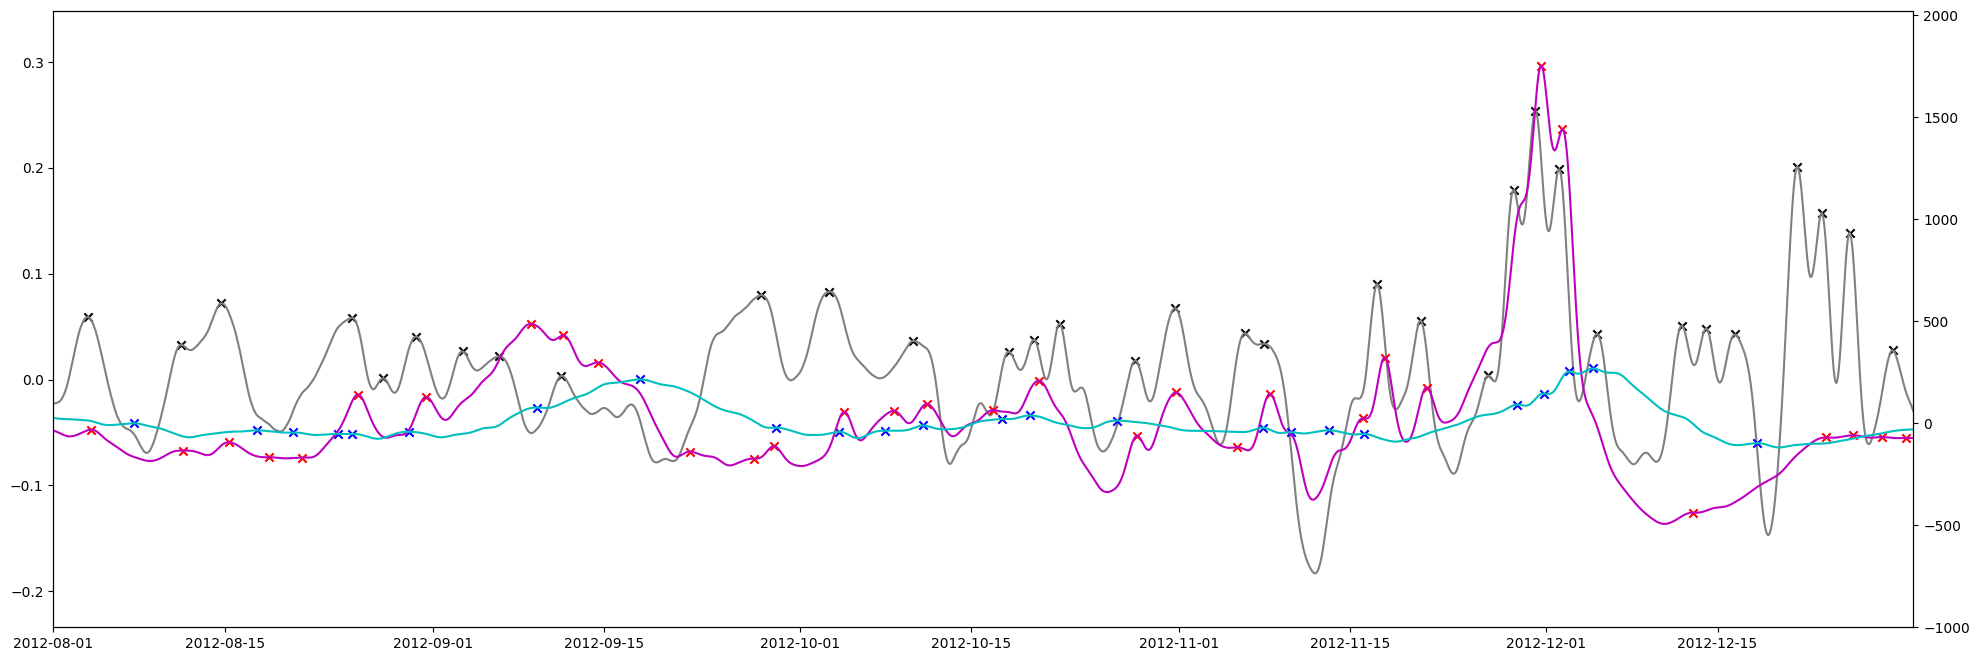

In [18]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(jp_indices[peaksjp],df_f_wo21.jp.loc[jp_indices[peaksjp]],label="Jersey Point",marker="x",color='r')
# ax1.plot(df_f_wo21.frk,color='g')
# ax1.scatter(df_f_wo21.datetime.iloc[peaksfrk],df_f_wo21.frk.iloc[peaksfrk],label="Franks Tract",marker="x",color='darkgreen')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(hol2_indices[peakshol2],df_f_wo21.hol2.loc[hol2_indices[peakshol2]],label="Holland Cut",marker="x",color='b')

ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
ax1.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])

(18475.0, 18627.0)

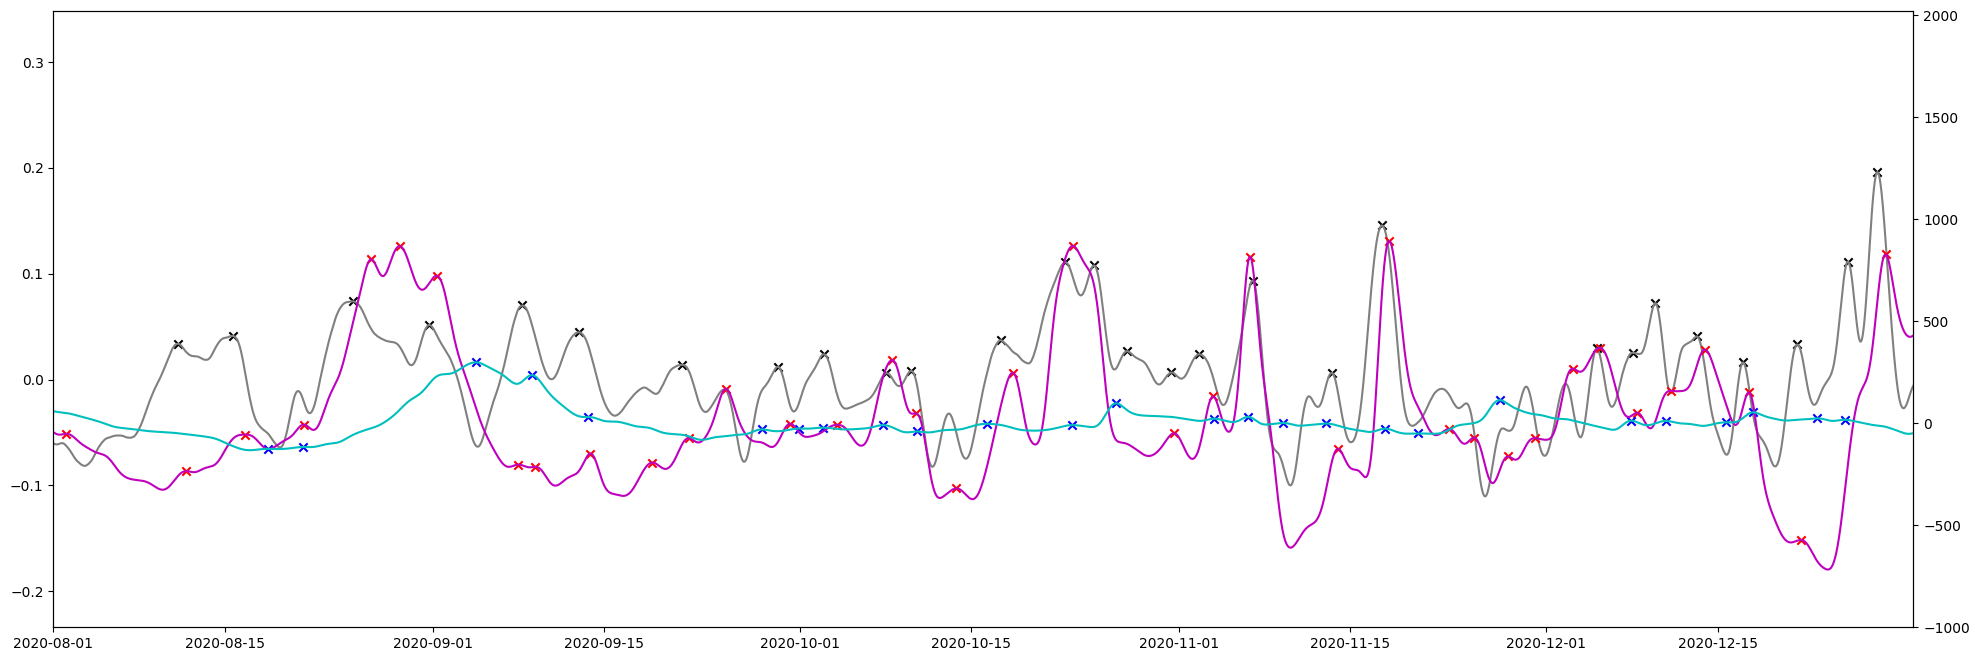

In [19]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(jp_indices[peaksjp],df_f_wo21.jp.loc[jp_indices[peaksjp]],label="Jersey Point",marker="x",color='r')
# ax1.plot(df_f_wo21.frk,color='g')
# ax1.scatter(df_f_wo21.datetime.iloc[peaksfrk],df_f_wo21.frk.iloc[peaksfrk],label="Franks Tract",marker="x",color='darkgreen')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(hol2_indices[peakshol2],df_f_wo21.hol2.loc[hol2_indices[peakshol2]],label="Holland Cut",marker="x",color='b')

ax.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])
ax1.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])

(18550.0, 18567.0)

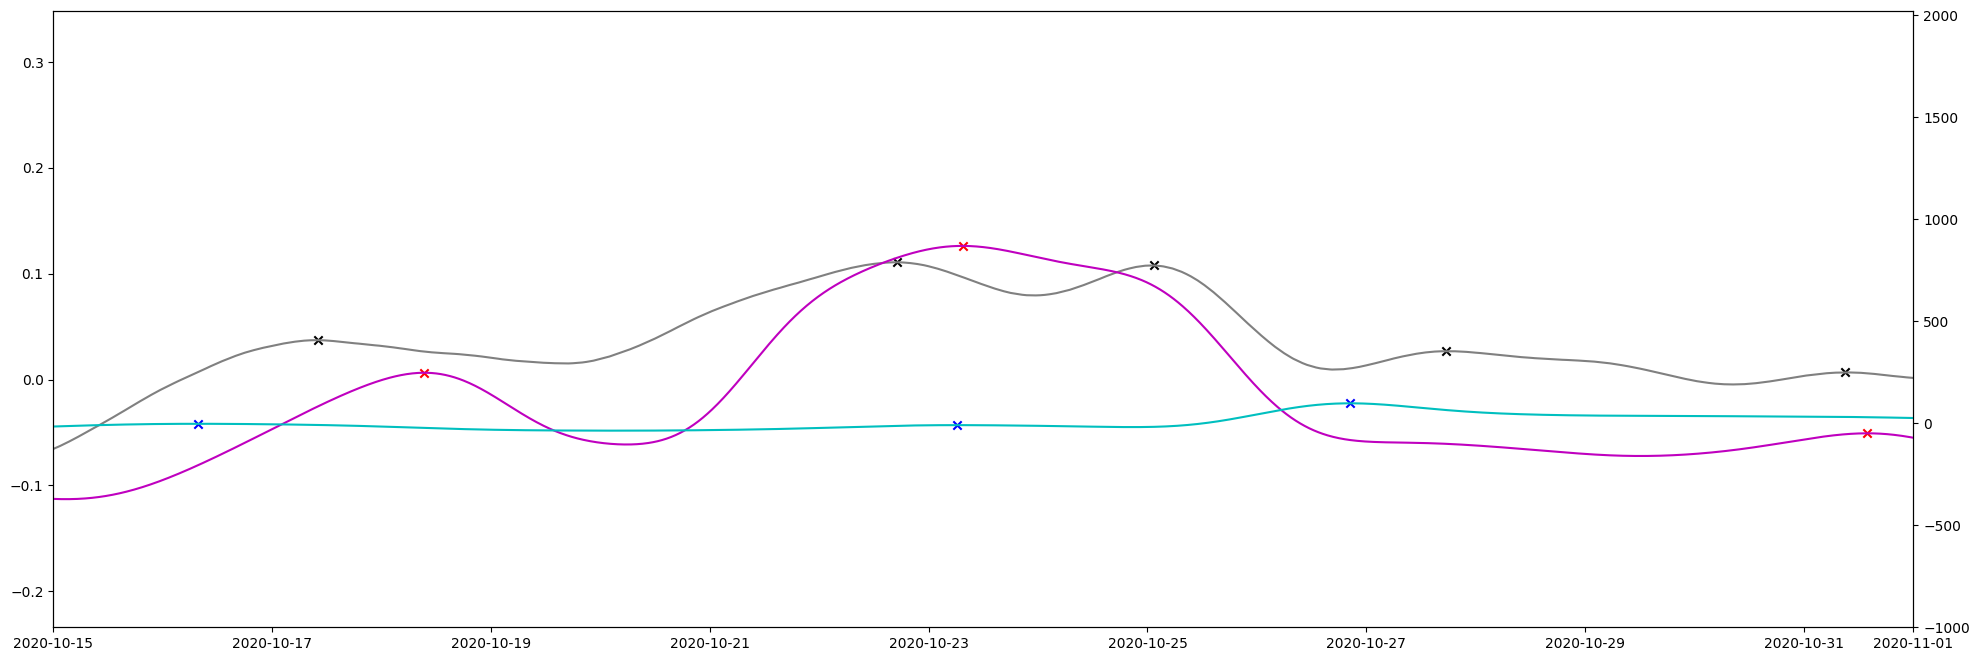

In [20]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(jp_indices[peaksjp],df_f_wo21.jp.loc[jp_indices[peaksjp]],label="Jersey Point",marker="x",color='r')
# ax1.plot(df_f_wo21.frk,color='g')
# ax1.scatter(df_f_wo21.datetime.iloc[peaksfrk],df_f_wo21.frk.iloc[peaksfrk],label="Franks Tract",marker="x",color='darkgreen')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(hol2_indices[peakshol2],df_f_wo21.hol2.loc[hol2_indices[peakshol2]],label="Holland Cut",marker="x",color='b')

ax.set_xlim([datetime(2020,10,15),datetime(2020,11,1)])
ax1.set_xlim([datetime(2020,10,15),datetime(2020,11,1)])

# Filter peaks

In [21]:
#make an array of ones to multiply by the true false
ov=np.ones_like(df_f_wo21['pr_peak'].values)

In [22]:
# as a first pass, how many events are there where there is a true value in all columns in the 24 hours after the pr peak?
peak_pr24h_1=np.datetime64()
peak_jp24h_1=np.datetime64()
peak_hol224h=np.datetime64()

# win=24 #number of samples in 24 hours
# winh=win*5
count_j=0
count_h=0
count_dup=0
old_hol2_time=pr_indices[0]
for p in peakspr:
    #need to map this index back to the data frame
    x=pr_indices[p]
    x2=x+pd.Timedelta(hours=win)
    x3=x+pd.Timedelta(hours=winh)
    if df_f_wo21.jp_peak[x:x2].sum()>0:
        jp_time=(x+pd.Timedelta(minutes=df_f_wo21.jp_peak[x:x2].argmax()*15)).to_datetime64()
        count_j=count_j+1
        if df_f_wo21.hol2_peak[x:x3].sum()>0: 
            hol2_time=(x+pd.Timedelta(minutes=df_f_wo21.hol2_peak[x:x3].argmax()*15)).to_datetime64()
            if hol2_time>jp_time: #and old_hol2_time!=hol2_time: #don't save the duplicate events
                count_h=count_h+1
                peak_pr24h_1=np.append(peak_pr24h_1,x.to_datetime64())
                #these should be in real time (don't drop na)
                peak_jp24h_1=np.append(peak_jp24h_1,jp_time)
                peak_hol224h=np.append(peak_hol224h,hol2_time)
            if old_hol2_time==hol2_time:
                count_dup=count_dup+1
            old_hol2_time=hol2_time
idx=np.arange(0,len(df_f_wo21.pr.values))

print(count_j)
print(count_h)
print(count_dup)
#df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

220
145
23


In [23]:
#trim the NaT from the beginning of the arrays
peak_pr24h_1=peak_pr24h_1[1:]
#peak_pr24h_2=peak_pr24h_2[1:]
peak_jp24h_1=peak_jp24h_1[1:]
#peak_jp24h_2=peak_jp24h_2[1:]
peak_hol224h=peak_hol224h[1:]
#peak_frk24h=peak_frk24h[1:]

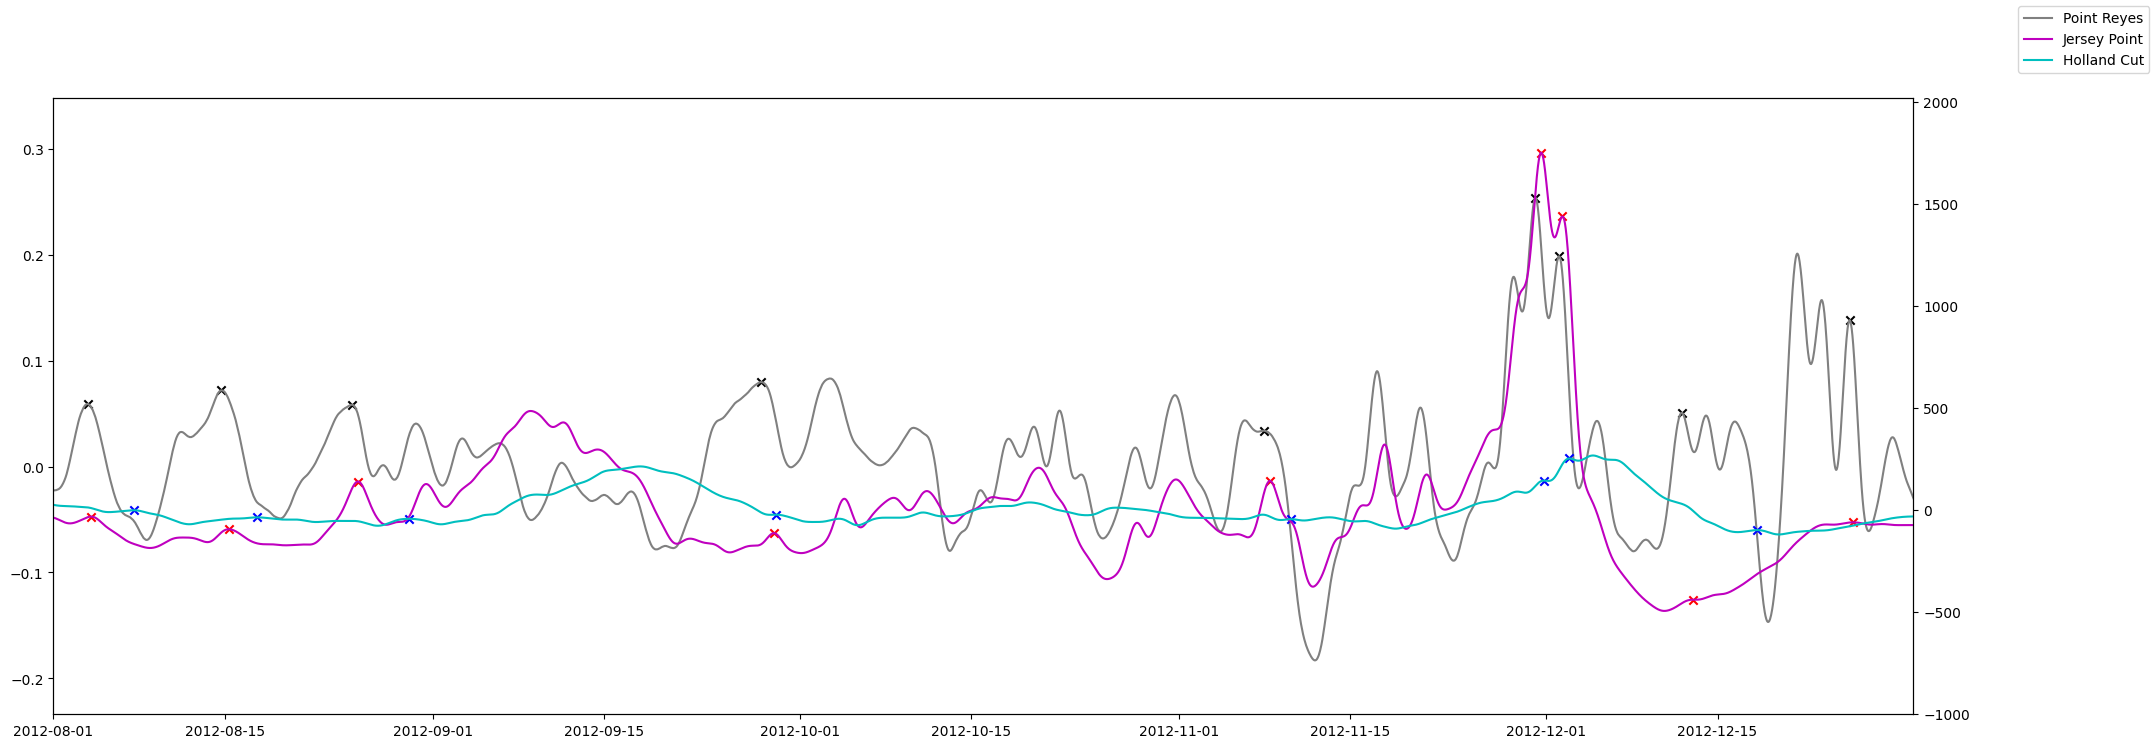

In [24]:
#Zoom into 2012
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
ax1.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
plt.show()

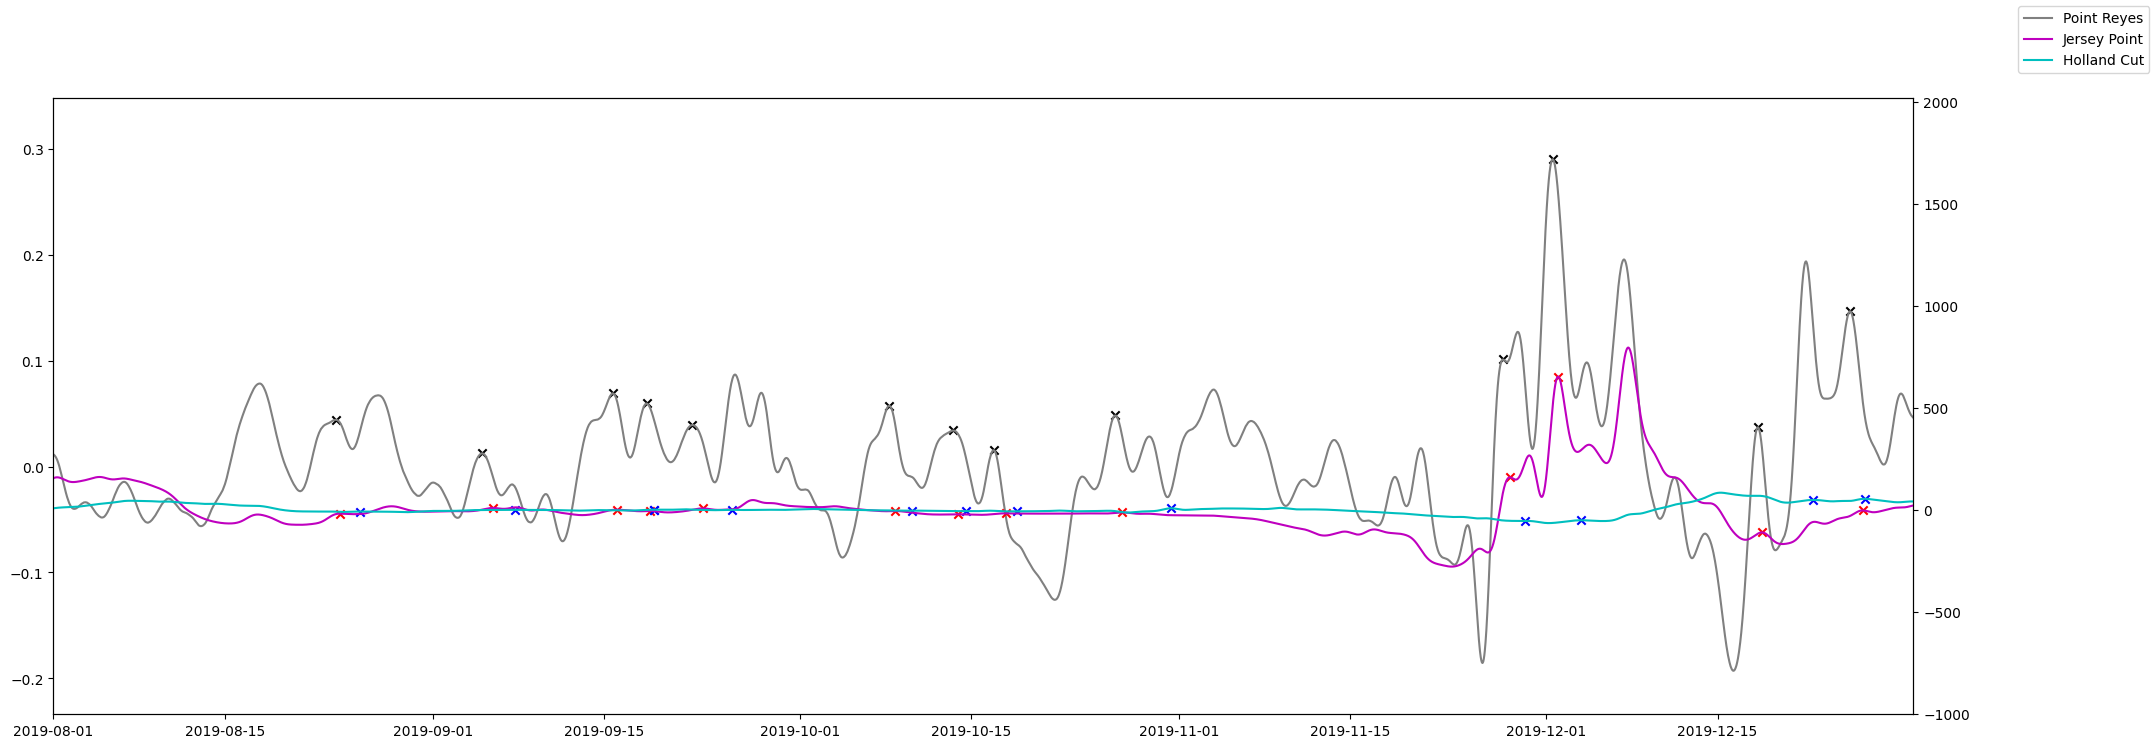

In [25]:
#Zoom into 2012
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2019,8,1),datetime(2019,12,31)])
ax1.set_xlim([datetime(2019,8,1),datetime(2019,12,31)])
plt.show()

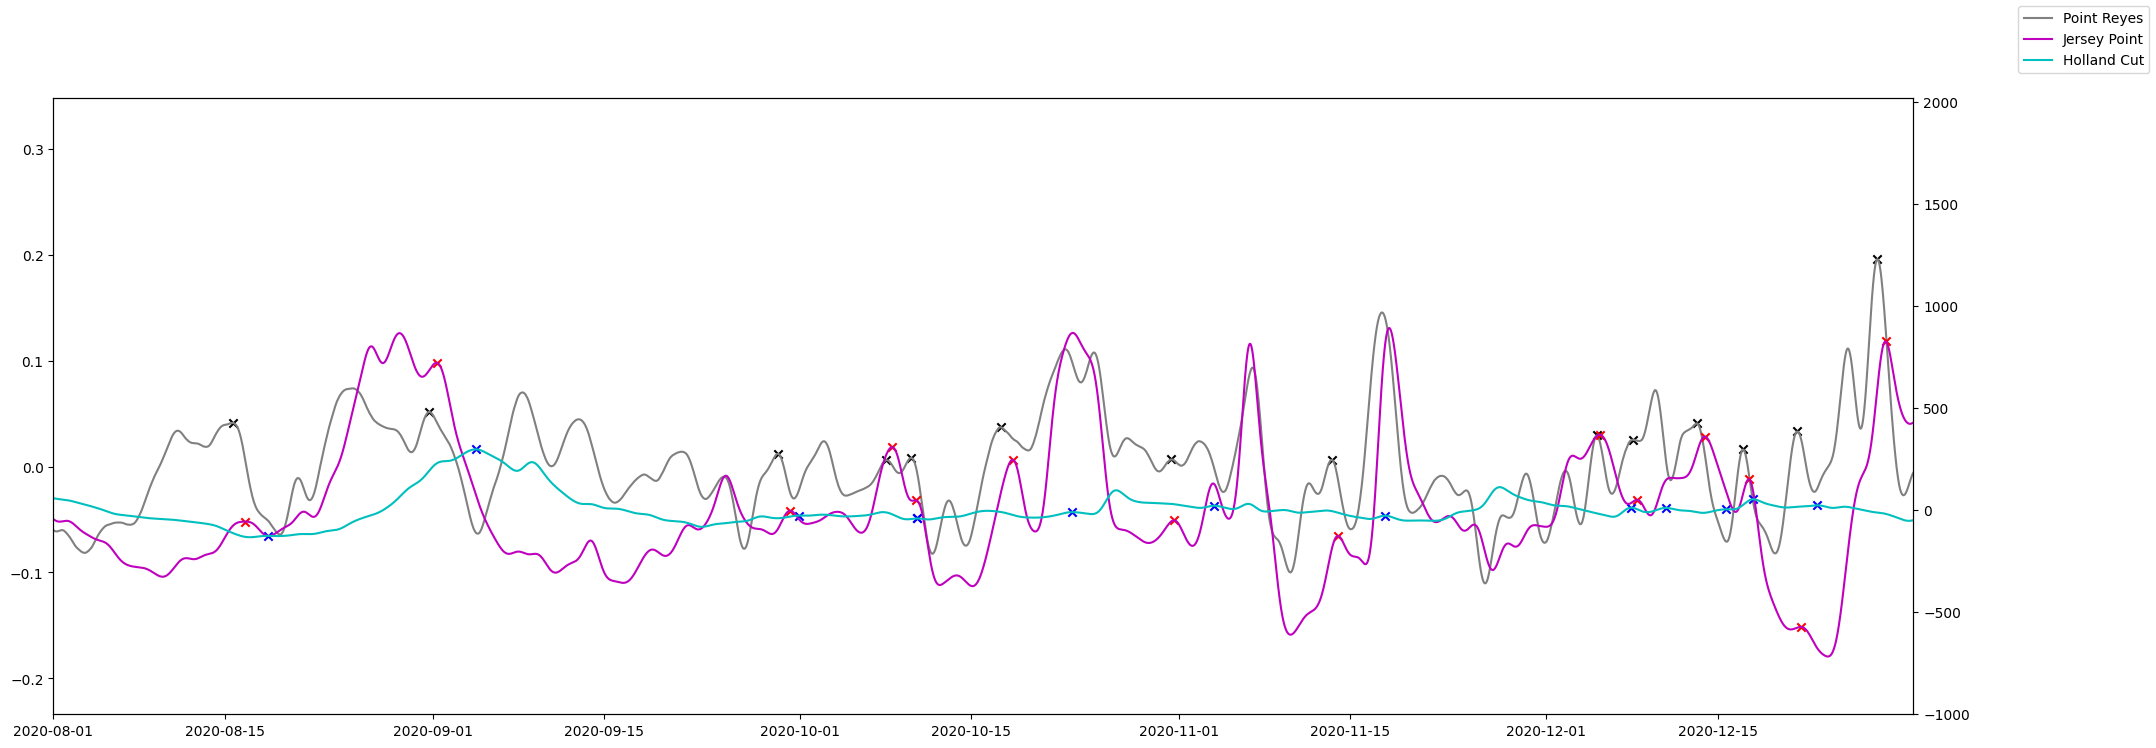

In [26]:
#Zoom into 2020
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])
ax1.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])
plt.show()

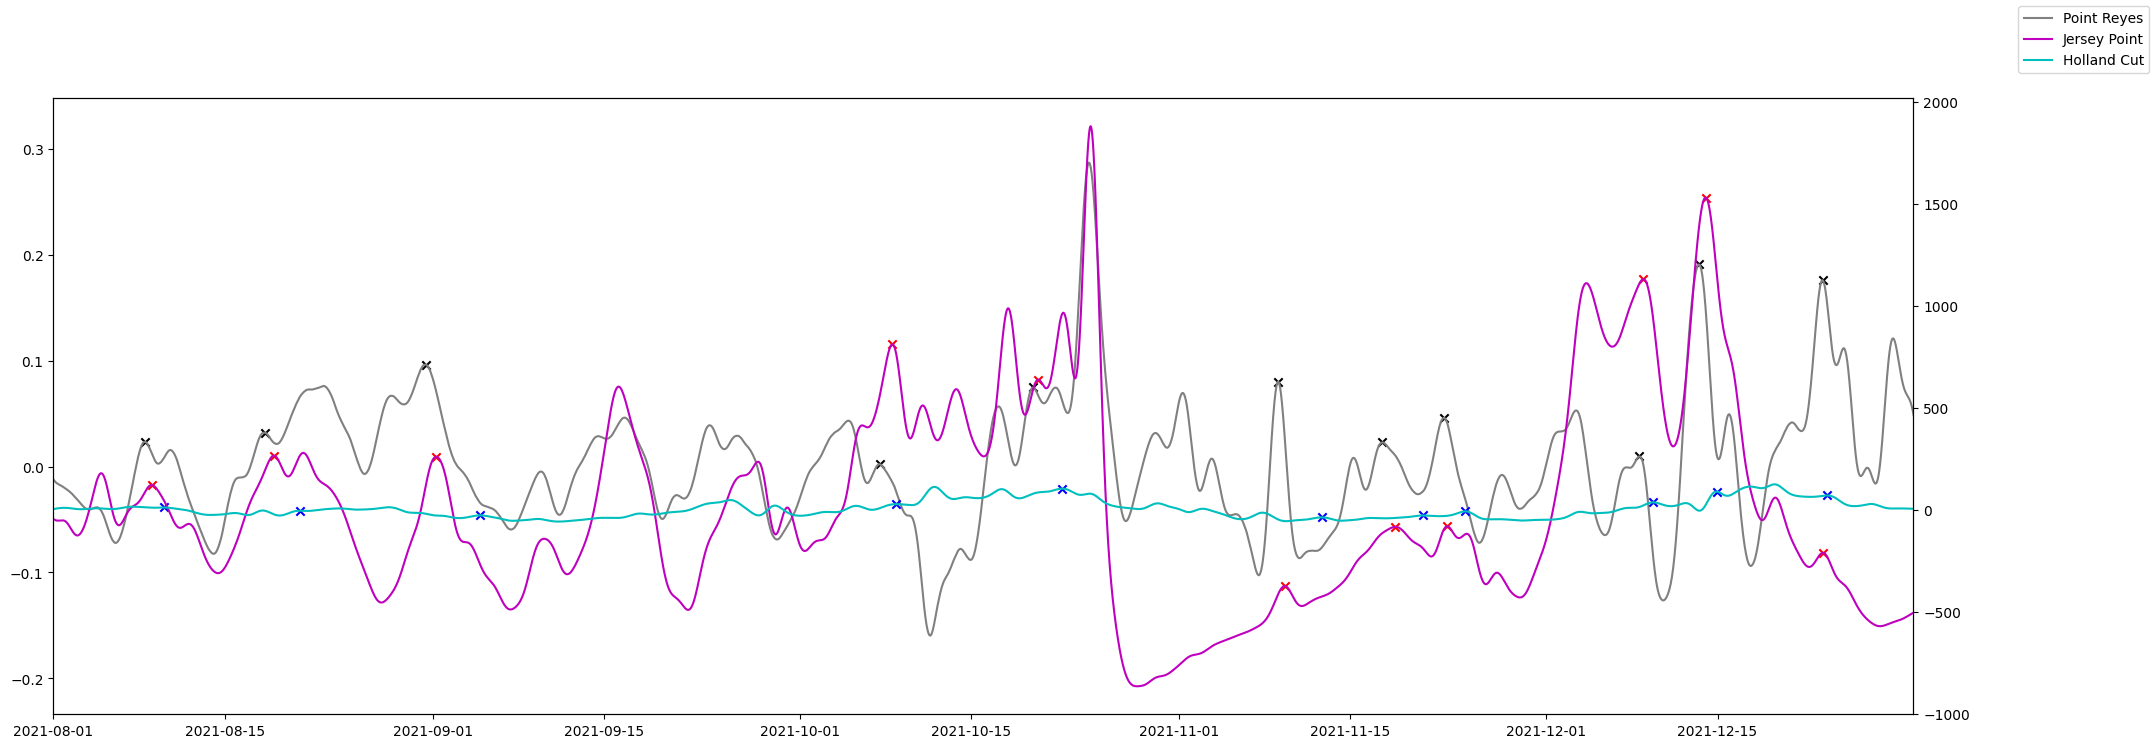

In [27]:
#Zoom into 2020
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2021,8,1),datetime(2021,12,31)])
ax1.set_xlim([datetime(2021,8,1),datetime(2021,12,31)])
plt.show()

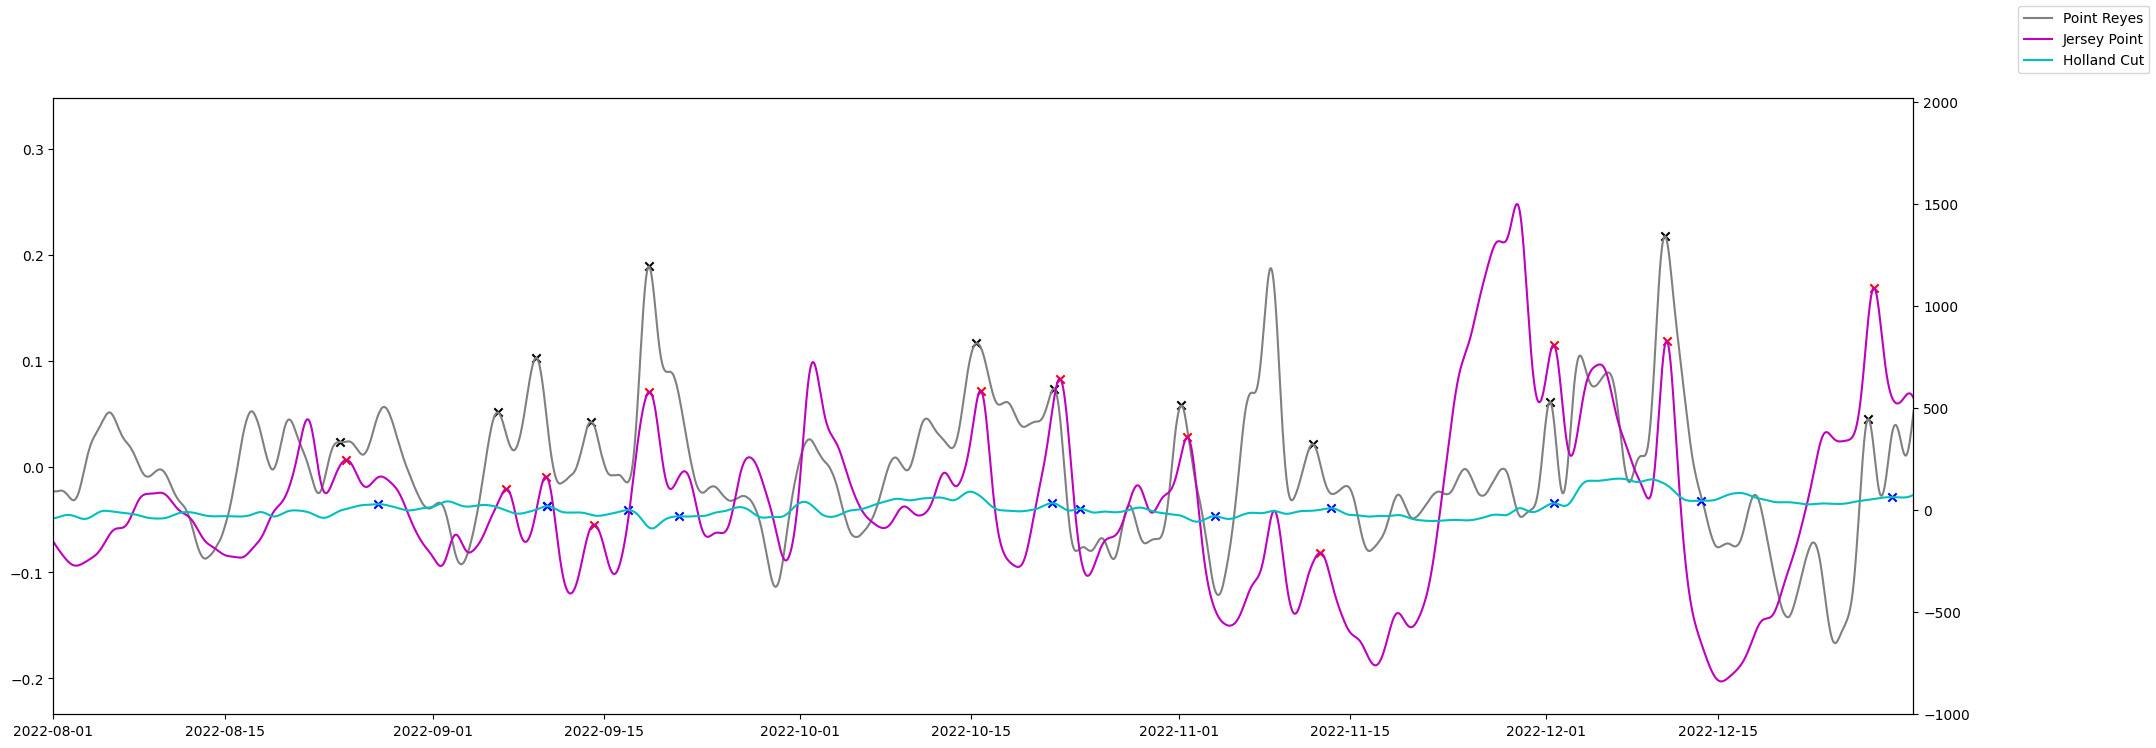

In [28]:
#Zoom into 2020
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2022,8,1),datetime(2022,12,31)])
ax1.set_xlim([datetime(2022,8,1),datetime(2022,12,31)])
plt.show()

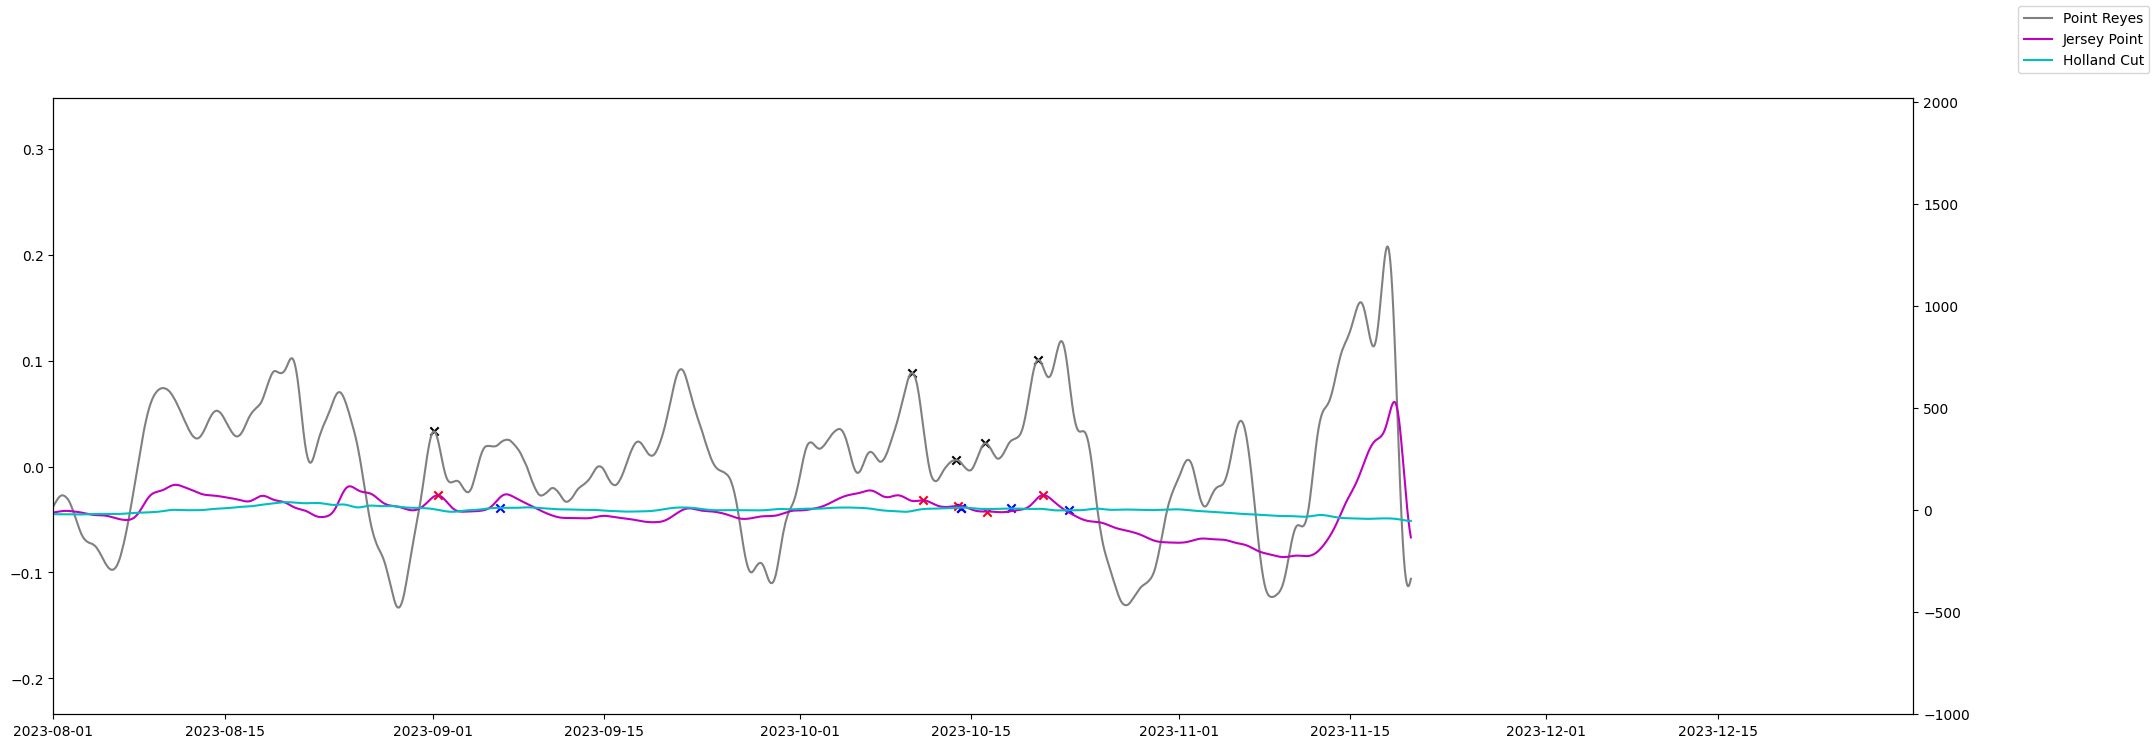

In [29]:
#Zoom into 2020
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2023,8,1),datetime(2023,12,31)])
ax1.set_xlim([datetime(2023,8,1),datetime(2023,12,31)])
plt.show()

# Plot the events with river flow and low pressure events

# function to calculate intensities

In [30]:
def unit_area(x,y,properties,peaks,dt,labelstr,peaksubset,plotflag):
    
    #where dt is the time resolution of x in hours
    if len(peaksubset)< len(peaks):
        peakidx=np.in1d(peaks,peaksubset)
    else:
        peakidx=np.arange(0,len(peaks))
    left=properties["left_ips"][peakidx]
    right=properties["right_ips"][peakidx]
    lind=np.round(left).astype(int)
    rind=np.round(right).astype(int)
    areav=np.array([])
    if plotflag==1:
        fig,ax =plt.subplots(figsize=(24,8))
        ax.plot(x,y,color='grey',linewidth=3)

    peaky=np.array([])
    
    for p in np.arange(0,len(lind)):
        #print(p)
        peak=y[lind[p]:rind[p]]
        peaky=np.append(peaky,np.max(peak))
        total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
        #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
        n_points=len(peak)
        peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
        area_bottom=trapz(peak_bottom,dx=dt) #dx is half an hour
        area=total_area-area_bottom
        #print(area)
        areav=np.append(areav, area)
        #check that we are selecting the right area of the peak
        if plotflag==1:
            ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
            ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
            ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
            ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
        #30 minute time resolution = .5 hours
    dur=(rind-lind)*dt
    inten_u=areav/dur
    months_for_colors=x[lind].month
    print(len(peaksubset))
    print(len(peaky))
    if plotflag==1:
        ax.scatter(peaksubset,peaky,label=labelstr,marker="x",color='k',linewidth=2)
        #limit x axis to 1/5 of the time period
        ax.set_xlim([x[0],x[(np.rint(len(x)/10)).astype(int)]])
        plt.show()
    return inten_u, dur, months_for_colors #units of elevation in m X time in hours


In [31]:
def extract_prop(properties,peaks,peaksubset,unit,dt,plotflag):
    #where properties is the object output from find_peaks associated with
    #peaks, but the peaks passed here should have the same units as peaksubset
    #typically datetime or unitless index
    #unit is the unit of the y data passed to find_peaks, either mS/cm^3 or 
    # m
    #dt is the amount of time between samples passed to find_peaks in hours
    #e.g. for the salinity data it should be 0.25 but for the SCHA pt reyes data 0.5
    if len(peaks)>len(peaksubset):
        peakidx=np.in1d(peaks,peaksubset)
    else:
        peakidx=np.arange(0,len(peaks))
    prominences=properties["prominences"][peakidx]
    widths=properties["widths"][peakidx]
    if plotflag==1:
        fig, ax = plt.subplots(1,2,layout='constrained')
        ax[0].hist(prominences)
        ax[1].hist(widths*dt)
        ax[0].set_xlabel('Peak prominence ['+unit+']')
        ax[1].set_xlabel('Peak width [h]')
    return prominences, widths

# intensity duration for the events that make it to holland cut

145
145


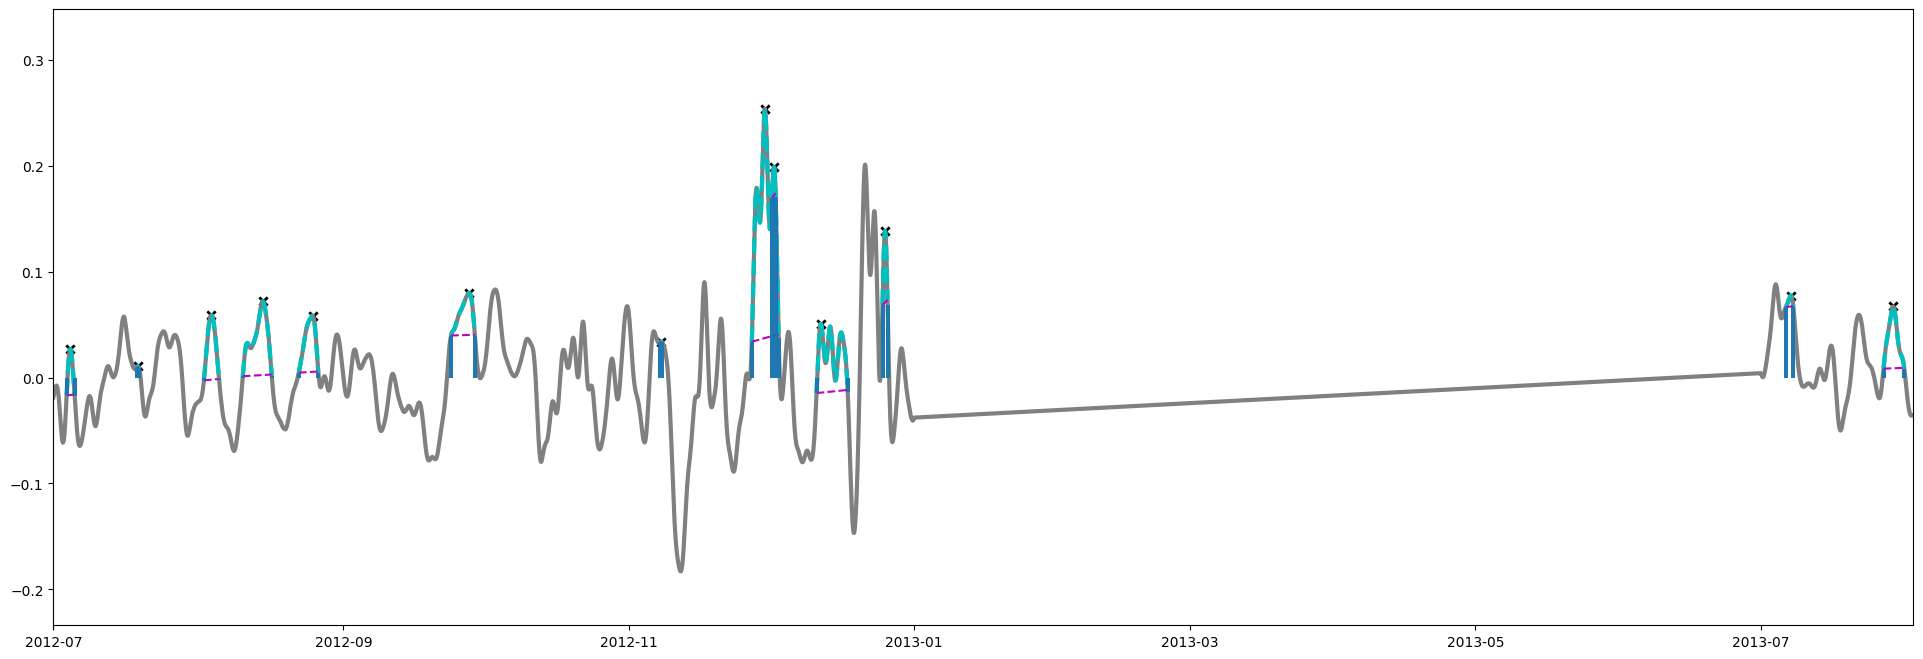

145
144
145
136


In [32]:
x_pr=df_f_wo21.pr.dropna().index
y_pr=df_f_wo21.pr.dropna().values
#unit_area(x,y,properties,peaks,dt,labelstr,peaksubset)
inten_u_pr, dur_pr, mfc_pr = unit_area(x_pr,y_pr,propertiespr,pr_indices[peakspr],0.5,'pt reyes',peak_pr24h_1,1)
x_jp=df_f_wo21.jp.dropna().index
y_jp=df_f_wo21.jp.dropna().values
inten_u_jp, dur_jp, mfc_jp = unit_area(x_jp,y_jp,propertiesjp,jp_indices[peaksjp],0.25,'Jersey Point',peak_jp24h_1,0)
x_hol2=df_f_wo21.hol2.dropna().index
y_hol2=df_f_wo21.hol2.dropna().values
inten_u_hol2, dur_hol2, mfc_hol2 = unit_area(x_hol2,y_hol2,propertieshol2,hol2_indices[peakshol2],0.25,'Holland Cut',peak_hol224h,0)

# x_hol2=df_f_wo21.hol2.dropna().index
# y_hol2=df_f_wo21.hol2.dropna().values
# inten_u_hol2, dur_hol2, mfc_hol2 = unit_area(x_hol2,y_hol2,propertieshol2,peakshol2,0.5,'Holland Cut',peak_hol224h)

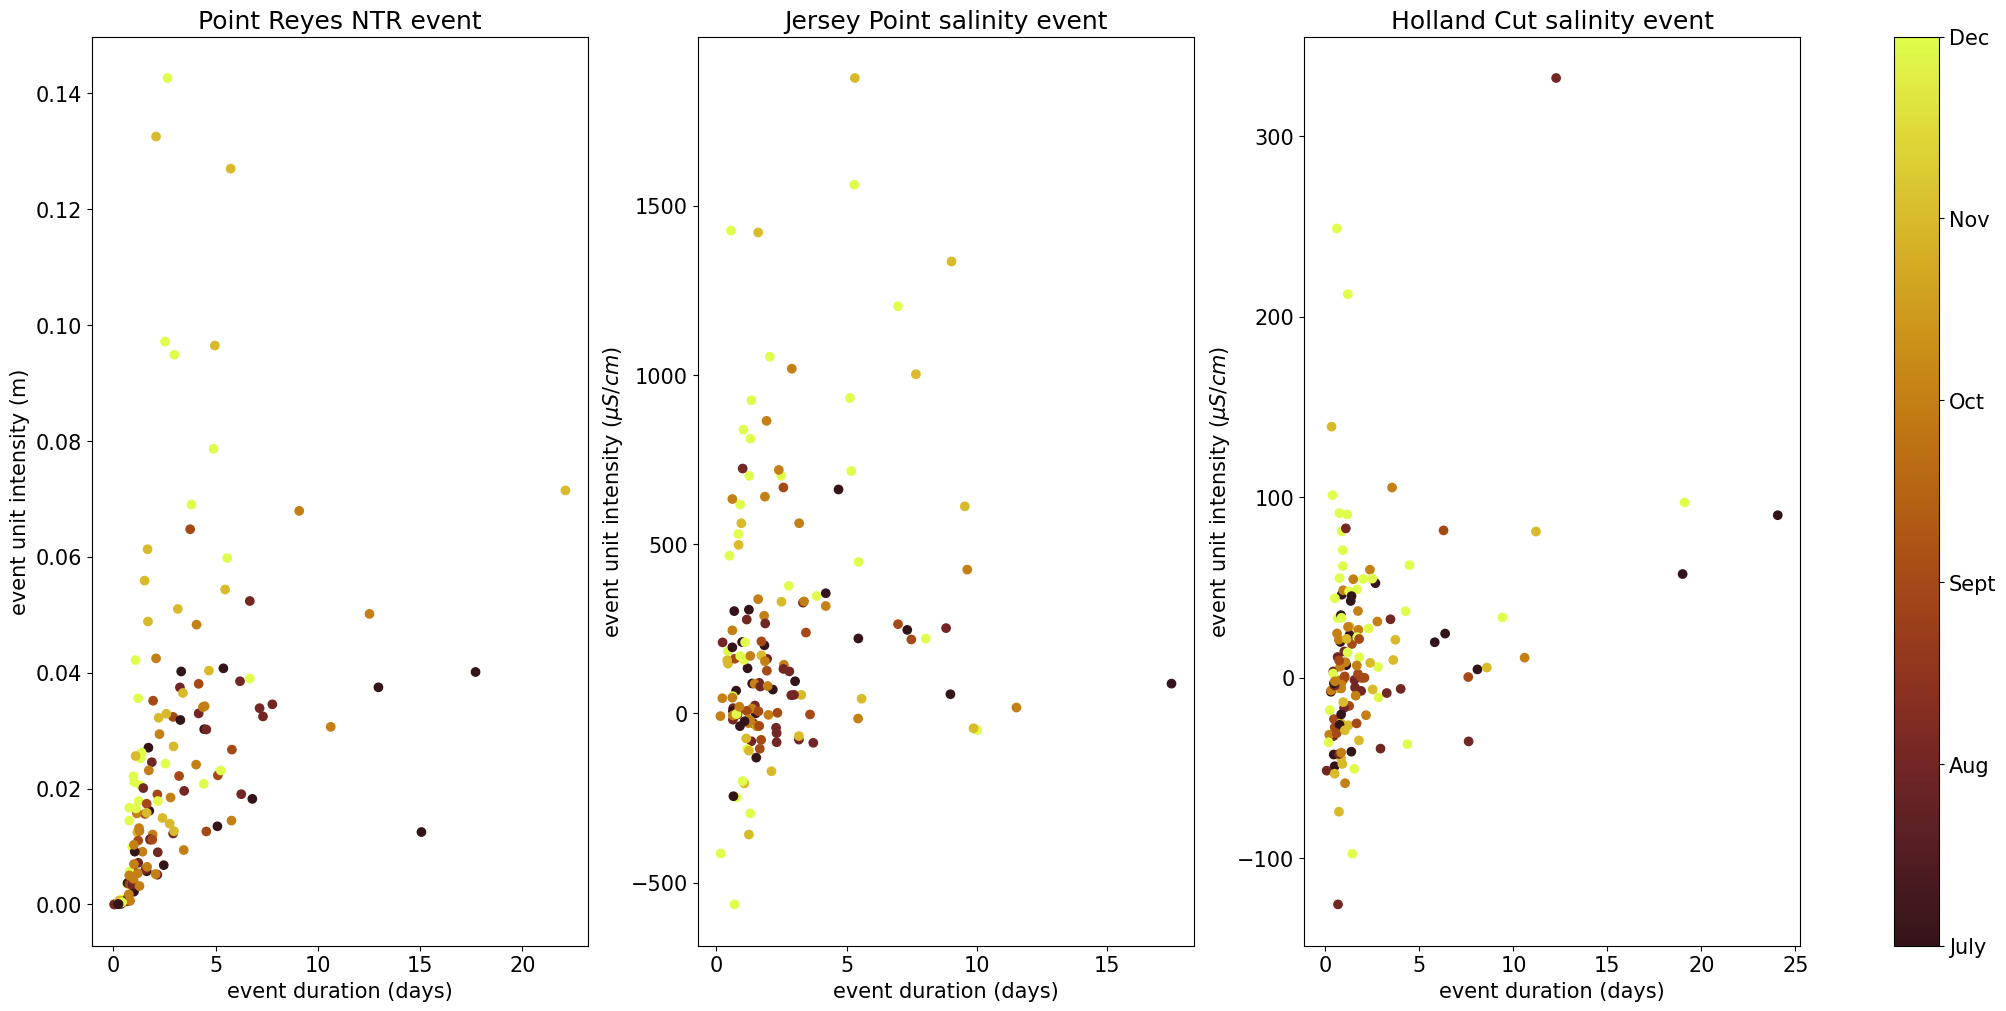

In [37]:
# Plot intensity- duration for each location
#add colorbar
fig, ax = plt.subplots(1,3,layout='constrained',figsize= (20,10))
# setting font sizeto 30
plt.rcParams.update({'font.size': 15})
pts0=ax[0].scatter(dur_pr/24,inten_u_pr,c=mfc_pr,cmap=cmocean.cm.solar)
ax[0].set_xlabel('event duration (days)')
ax[0].set_ylabel('event unit intensity (m)')
#ax[1].set_xlim(0,12)
ax[0].set_title('Point Reyes NTR event')
# cbar=fig.colorbar(pts0, ax=ax)
# cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])

pts1=ax[1].scatter(dur_jp/24,inten_u_jp,c=mfc_jp,cmap=cmocean.cm.solar)
ax[1].set_xlabel('event duration (days)')
ax[1].set_ylabel('event unit intensity ($\mu S/cm$)')
#ax[1].set_xlim(0,12)
ax[1].set_title('Jersey Point salinity event')

pts2=ax[2].scatter(dur_hol2/24,inten_u_hol2,c=mfc_hol2,cmap=cmocean.cm.solar)
ax[2].set_xlabel('event duration (days)')
ax[2].set_ylabel('event unit intensity ($\mu S/cm$)')
#ax[1].set_xlim(0,12)
ax[2].set_title('Holland Cut salinity event')


cbar=fig.colorbar(pts2, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

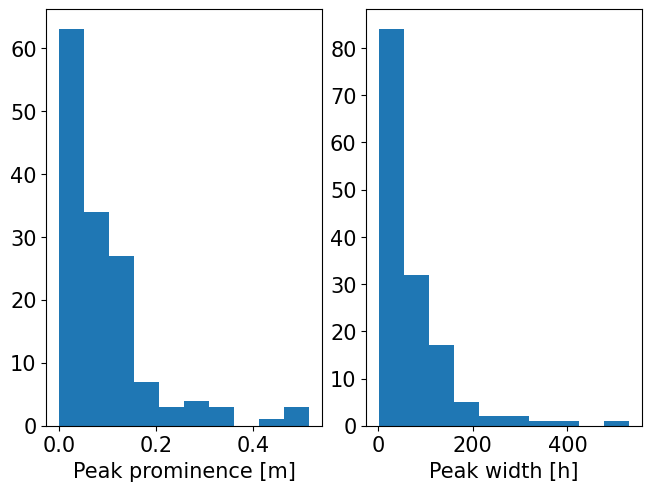

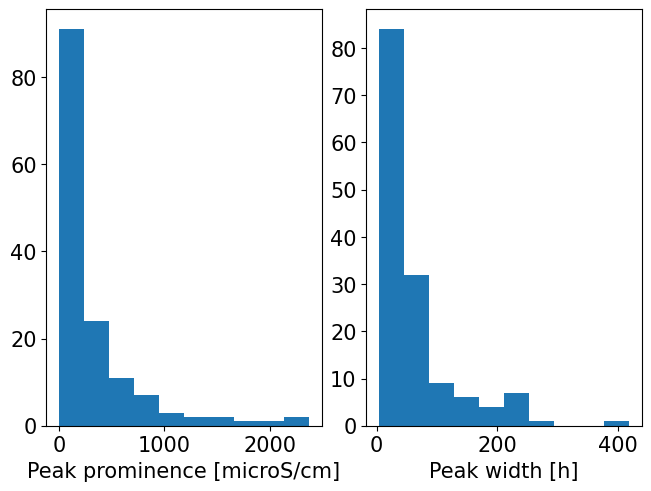

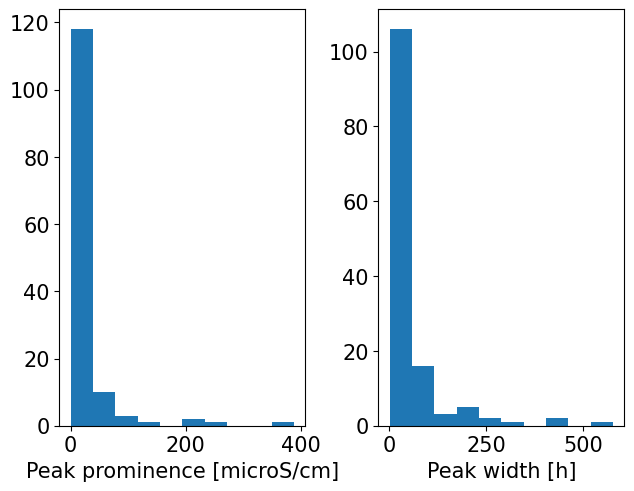

In [34]:
prominencespr, widthspr = extract_prop(propertiespr,pr_indices[peakspr],peak_pr24h_1,'m',0.5,1)
prominencesjp, widthsjp = extract_prop(propertiesjp,jp_indices[peaksjp],peak_jp24h_1,'microS/cm',0.25,1)
prominenceshol2, widthshol2 = extract_prop(propertieshol2,hol2_indices[peakshol2],peak_hol224h,'microS/cm',0.25,1)

# Lags between different locations?

In [35]:
#subtract the dates in each peak_*24h
jp_lags=(peak_jp24h_1-peak_pr24h_1).astype(np.float)/(10**9*60*60) #convert from ns to h
hol2_lags=(peak_hol224h-peak_pr24h_1).astype(np.float)/(10**9*60*60) #convert from ns to h

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel pac

Text(0.5, 0, 'Lag [h] P Reyes and Holl Cut')

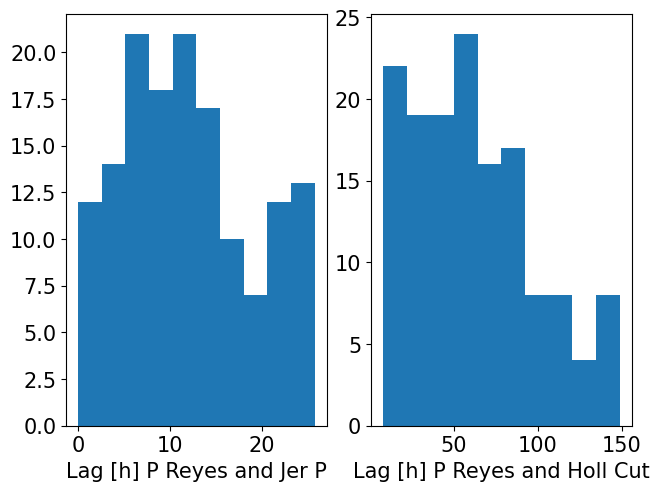

In [36]:
fig, ax =plt.subplots(1,2,layout='constrained')

ax[0].hist(jp_lags)
ax[1].hist(hol2_lags)
ax[0].set_xlabel('Lag [h] P Reyes and Jer P')
ax[1].set_xlabel('Lag [h] P Reyes and Holl Cut')

# Find the start and end days of the point reyes events

In [69]:
# make a dataframe with the peak date, start time, and end time and write to a csv
def write_peak_dates(properties,peaks,peaksubset,timevector,writepath=np.nan):
    #where properties is the object output from find_peaks associated with
    #peaks, but the peaks passed here should have the same units as peaksubset
    #typically datetime or unitless index
    #unit is the unit of the y data passed to find_peaks, either mS/cm^3 or 
    # m
    #dt is the amount of time between samples passed to find_peaks in hours
    #e.g. for the salinity data it should be 0.25 but for the SCHA pt reyes data 0.5
    if len(peaks)>len(peaksubset):
        peakidx=np.in1d(peaks,peaksubset) #true false
    else:
        peakidx=np.arange(0,len(peaks))
    #print(peaks)
    left=properties["left_ips"][peakidx]
    right=properties["right_ips"][peakidx]
    #print(np.rint(left).astype(int))
    # left and right are interpolated positions,to map these indices back to datetimes from timevector need to round to nearest integer
    starttime=timevector[np.rint(left).astype(int)]
    endtime=timevector[np.rint(right).astype(int)]
    datearray=np.c_[peaksubset,starttime,endtime]
    peakdatesdf=pd.DataFrame(data=datearray,columns={'Max','Start','End'})
    if pd.isnull(writepath)==False:
        peakdatesdf.to_csv(writepath)
    return peakdatesdf


In [70]:
peakdatespr = write_peak_dates(propertiespr,pr_indices[peakspr],peak_pr24h_1,pr_indices,'/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/pr_peaks_2025_12_18.csv')
peakdatespr

,Max,Start,End
0,2012-07-04 15:00:00,2012-07-03 20:00:00,2012-07-05 13:00:00
1,2012-07-19 02:00:00,2012-07-18 19:00:00,2012-07-19 07:00:00
2,2012-08-03 19:00:00,2012-08-02 04:30:00,2012-08-05 10:30:00
3,2012-08-14 17:30:00,2012-08-10 12:00:00,2012-08-16 16:30:00
4,2012-08-25 10:30:00,2012-08-22 11:30:00,2012-08-26 15:30:00
...,...,...,...
140,2023-09-01 02:30:00,2023-08-31 10:00:00,2023-09-01 21:00:00
141,2023-10-10 03:30:00,2023-10-08 20:00:00,2023-10-11 02:00:00
142,2023-10-13 19:00:00,2023-10-13 01:30:00,2023-10-14 08:00:00
143,2023-10-16 04:00:00,2023-10-15 17:30:00,2023-10-16 17:00:00


In [ ]:
prominencespr, widthspr = extract_prop(propertiespr,pr_indices[peakspr],peak_pr24h_1,'m',0.5,1)
prominencesjp, widthsjp = extract_prop(propertiesjp,jp_indices[peaksjp],peak_jp24h_1,'microS/cm',0.25,1)
prominenceshol2, widthshol2 = extract_prop(propertieshol2,hol2_indices[peakshol2],peak_hol224h,'microS/cm',0.25,1)